# Training

In [ ]:
import os
import numpy as np
import torch
import time
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd import Variable
from pathlib import Path

%matplotlib inline

In [ ]:
#importing training options
#os.chdir("../")
import config.train_opt as opt

In [ ]:
pix2pixhd_dir = Path('./src/pix2pixHD/')

import sys
sys.path.append(str(pix2pixhd_dir))

%load_ext autoreload
%autoreload 2

In [ ]:
# from options.train_options import TrainOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
import util.util as util
from util.visualizer import Visualizer

In [ ]:

with open('./config/train_opt.pkl', mode='rb') as f:
     opt = pickle.load(f)

iter_path = os.path.join(opt.checkpoints_dir, opt.name, 'iter.txt')

In [ ]:
#tuning parameters
opt.dataroot="./dataset_test"
#18
opt.label_nc=0
opt.fp16=False
#avoid overwriting in checkpoints folder
opt.name="Pose_Game_test"
opt.load_pretrain="./checkpoints/Pose_Game/"
#opt.isTrain = False
opt.checkpoints_dir="./checkpoints/"
#opt.use_encoded_image = True

In [ ]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training images = %d' % dataset_size)
    
start_epoch, epoch_iter=1, 0
total_steps=(start_epoch-1) * dataset_size + epoch_iter
display_delta=total_steps % opt.display_freq
print_delta=total_steps % opt.print_freq
save_delta=total_steps % opt.save_latest_freq


CustomDatasetDataLoader
dataset [AlignedDataset] was created
#training images = 26000



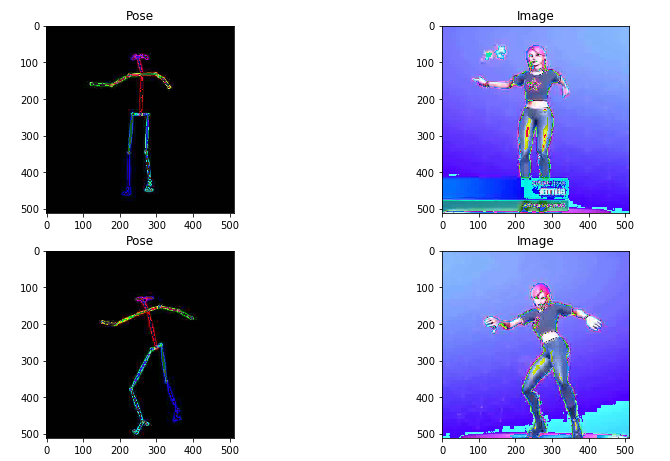

In [ ]:
#for Visualization purposes
fig = plt.figure(figsize = [13,20])
for i,temp in enumerate(dataset):
    #Pose
    plt.subplot(2,2,i*2+1)
    plt.title("Pose")
    plt.imshow(temp['label'][0].permute(1,2,0))
    
    #Image
    plt.subplot(2,2,(i+1)*2)
    plt.title("Image")
    plt.imshow(temp['image'][0].permute(1,2,0))

    if i==4:
        break
plt.show()  

In [ ]:
opt.isTrain=True
opt.use_encoded_image=True

model = create_model(opt)
visualizer = Visualizer(opt)


GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, aff

In [ ]:
epoch=1
i=0
for data in tqdm(dataset):
    iter_start_time = time.time()
    total_steps+=1
    epoch_iter+=1

    #forward pass
    losses, generated = model(Variable(data['label']), Variable(data['inst']), 
        Variable(data['image']), Variable(data['feat']), infer=True)

    #sum per device losses
    losses = [ torch.mean(x) if not isinstance(x, int) else x for x in losses ]
    loss_dict = dict(zip(model.module.loss_names, losses))

    # calculate final loss scalar
    loss_D = (loss_dict['D_fake'] + loss_dict['D_real']) * 0.5
    loss_G = loss_dict['G_GAN'] + loss_dict.get('G_GAN_Feat',0) + loss_dict.get('G_VGG',0)


    #results and errors
    ### print errors
    errors = {k: v.item() if not isinstance(v, int) else v for k, v in loss_dict.items()}
    t = (time.time() - iter_start_time) / opt.batchSize
    visualizer.print_current_errors(epoch, epoch_iter, errors, t)
    visualizer.plot_current_errors(errors, total_steps)

    #output images
    visuals = OrderedDict([('input_label', util.tensor2label(data['label'][0], opt.label_nc)),
                           ('synthesized_image', util.tensor2im(generated.data[0])),
                           ('real_image', util.tensor2im(data['image'][0]))])
    visualizer.display_current_results(visuals, i, total_steps)

    #error             
    np.savetxt(iter_path, (epoch, epoch_iter), delimiter=',', fmt='%d')
    i+=1


torch.cuda.empty_cache()


(epoch: 1, iters: 640, time: 1.553) G_GAN_Feat: 4.915 G_VGG: 3.018 G_GAN: 1.165 D_fake: 0.163 D_real: 0.162 
saving the latest model (epoch 1, total_steps 640)
(epoch: 1, iters: 1280, time: 1.550) G_GAN_Feat: 3.078 G_VGG: 2.444 G_GAN: 1.325 D_fake: 0.295 D_real: 0.838 
saving the latest model (epoch 1, total_steps 1280)
(epoch: 1, iters: 1920, time: 1.558) G_GAN_Feat: 3.828 G_VGG: 3.234 G_GAN: 1.055 D_fake: 0.177 D_real: 0.382 
saving the latest model (epoch 1, total_steps 1920)
(epoch: 1, iters: 2560, time: 1.549) G_GAN_Feat: 4.356 G_VGG: 2.859 G_GAN: 0.464 D_fake: 0.648 D_real: 0.353 
saving the latest model (epoch 1, total_steps 2560)
(epoch: 1, iters: 3200, time: 1.548) G_GAN_Feat: 4.516 G_VGG: 2.480 G_GAN: 0.864 D_fake: 0.290 D_real: 0.378 
saving the latest model (epoch 1, total_steps 3200)
(epoch: 1, iters: 3840, time: 1.579) G_GAN_Feat: 2.958 G_VGG: 2.157 G_GAN: 1.055 D_fake: 0.195 D_real: 0.874 
saving the latest model (epoch 1, total_steps 3840)
(epoch: 1, iters: 4480, time:

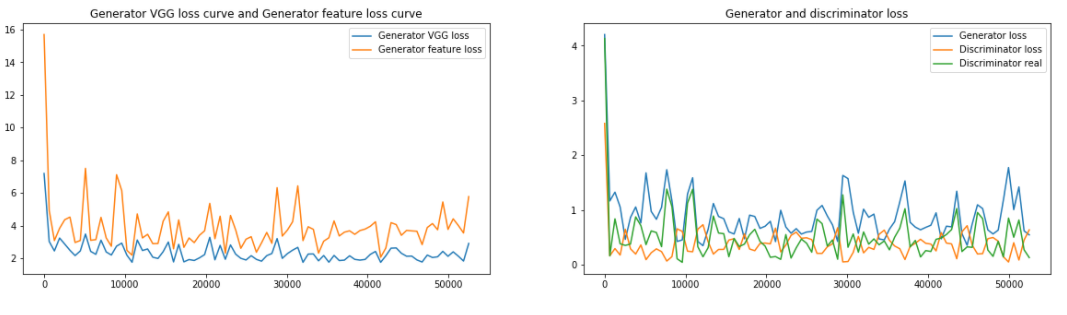

In [ ]:
#vis train loss
#initially:  G_GAN_Feat: 15.700 D_real: 4.131 G_GAN: 4.203 G_VGG: 7.186 D_fake: 2.581 
G_gan_feat = 0
G_gan = 0
D_fake = 0
D_real = 0
G_vgg = 0
iters = 0
with open("./checkpoints/Pose_Game_test/loss_log.txt") as fp:
    line = fp.readline()
    cnt = 1
    while line:
        if "G_GAN_Feat:" in line.split():
            A = line.split()
            G_gan_feat+=(float(A[7]))
            G_vgg+=(float(A[9]))
            G_gan+=(float(A[11]))
            D_fake+=(float(A[13]))
            D_real+=(float(A[15]))
            iters = int(A[3][:-1]) 
        line = fp.readline()
        cnt += 1
print("Test results on {} samples\nG_gan_feat:{}\nG_vgg:{}\nG_gan:{}\nD_fake:{}\nD_real:{}".format(iters,G_gan_feat/iters,G_vgg/iters,G_gan/iters,D_fake/iters,D_real/iters))